In [94]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import os
import keras
import itertools
from glob import glob
from os.path import splitext
from PIL import Image
import numpy as np
import pandas as pd
import datetime
from keras.layers import BatchNormalization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
lat = 25.03
if not os.path.exists('x_data.npy'):
    x_data = []
    effective_list = []
    solar_coefficient = []
    day_index = 1
    for yyyy in [2018, 2019, 2020]:
        for mm in range(1, 13):
            for dd in range(1, 32):
                # Check whether the date is valid
                isValidDate = True
                try :
                    datetime.datetime(yyyy, mm, dd)
                except ValueError :
                    isValidDate = False            
                if isValidDate and datetime.datetime(yyyy, mm, dd) < datetime.datetime(2020, 7, 13):
                    for zz in range(1, 9):
                        solar_declination = np.arcsin(np.sin(-23.44/180*np.pi)*np.cos((2*np.pi/365.24*(day_index%365+10))+(2*0.0167*np.sin(2*np.pi/365.24*(day_index%365-2))))) # in radiㄙ
                        cos_solar_zenith = np.sin(lat/180*np.pi)*np.sin(solar_declination) + np.cos(lat/180*np.pi)*np.cos(solar_declination)*np.cos(15*(zz-4)/180*np.pi)
                        solar_coefficient.append([[[cos_solar_zenith]]])
                        try:
                            # open image file
                            im = Image.open('img/vis_{:04d}_{:02d}_{:02d}_{:02d}LST.png'.format(yyyy, mm, dd, zz+8))
                            """
                            plt.figure(figsize=(16,16))
                            x1, x2 = 347, 357
                            y1, y2 = 135, 145
                            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r')
                            plt.imshow(im)
                            plt.show()
                            """
                            crop = im.crop((347, 135, 357, 145))
                            if (np.array(crop) == np.zeros((10, 10, 3))).all():
                                print('image file img/vis_{:04d}_{:02d}_{:02d}_{:02d}LST.png is empty'.format(yyyy, mm, dd, zz+8))
                                x_data.append(np.full((10, 10, 3), np.nan))
                                effective_list.append(False)
                            else:
                                x_data.append(np.array(crop))
                                effective_list.append(True)
                        except:
                            print('cannot identify image file img/vis_{:04d}_{:02d}_{:02d}_{:02d}LST.png'.format(yyyy, mm, dd, zz+8))
                            x_data.append(np.full((10, 10, 3), np.nan))
                            effective_list.append(False)
                        
                        day_index += 1
    x_data = np.array(x_data)
    np.save('x_data.npy', x_data)
    effective_list = np.array(effective_list)
    np.save('effective_list.npy', effective_list)
    solar_coefficient = np.array(solar_coefficient)
    np.save('solar_coefficient.npy', solar_coefficient)
else:
    x_data = np.load('x_data.npy')
    effective_list = np.load('effective_list.npy')
    solar_coefficient = np.load('solar_coefficient.npy')

In [5]:
train_data = np.concatenate((x_data.reshape((7392, 300))/255, solar_coefficient.reshape((7392, 1))), axis=1)
result = pd.read_csv('radiation.csv')
result.head()
X = train_data[effective_list]
Y = np.array(result['GloblRad'][effective_list])
print(X.shape)
print(Y.shape)
total = Y.shape[0]
print(total)

split = total*4//5
# split trainig and testing data
x_train, y_train = X[:split], Y[:split] 
x_test, y_test = X[split:], Y[split:]
print(x_train.shape[1:])

(7358, 301)
(7358,)
7358
(301,)


In [95]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, 
                           activation='relu', 
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(128, 
                           activation='relu'))
    #model.add(layers.Dense(128, 
    #                       activation='relu'))
    #model.add(layers.Dense(128, 
    #                       activation='relu'))
    #model.add(layers.Dense(64, 
    #                       activation='relu'))
    model.add(layers.Dense(64,
                           activation='relu'))
    model.add(layers.Dense(1)) # activation function will limit putput range
    model.compile(optimizer='rmsprop',#'adam'
                  loss='mse',
                  metrics=['mae'])
    return model

Processing fold # 0
Train on 4415 samples, validate on 1471 samples
Epoch 1/150
4415/4415 [==============================] - 1s 122us/step - loss: 0.9247 - mae: 0.7381 - val_loss: 0.3923 - val_mae: 0.5067
Epoch 2/150
4415/4415 [==============================] - 0s 99us/step - loss: 0.5043 - mae: 0.5633 - val_loss: 0.3930 - val_mae: 0.5231
Epoch 3/150
4415/4415 [==============================] - 0s 100us/step - loss: 0.4335 - mae: 0.5173 - val_loss: 0.3711 - val_mae: 0.4826
Epoch 4/150
4415/4415 [==============================] - 0s 102us/step - loss: 0.4110 - mae: 0.5050 - val_loss: 0.2980 - val_mae: 0.4472
Epoch 5/150
4415/4415 [==============================] - 0s 103us/step - loss: 0.4039 - mae: 0.5001 - val_loss: 0.3064 - val_mae: 0.4573
Epoch 6/150
4415/4415 [==============================] - 0s 104us/step - loss: 0.3899 - mae: 0.4927 - val_loss: 0.3348 - val_mae: 0.4767
Epoch 7/150
4415/4415 [==============================] - 0s 103us/step - loss: 0.3628 - mae: 0.4782 - val_loss:

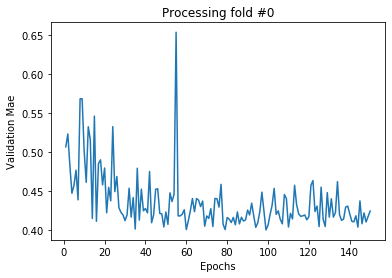

1472/1472 [==============================] - 0s 33us/step
Processing fold # 1
Train on 4415 samples, validate on 1471 samples
Epoch 1/150
4415/4415 [==============================] - 1s 127us/step - loss: 0.9091 - mae: 0.7499 - val_loss: 0.4144 - val_mae: 0.5250
Epoch 2/150
4415/4415 [==============================] - 0s 99us/step - loss: 0.4856 - mae: 0.5546 - val_loss: 0.3711 - val_mae: 0.4855
Epoch 3/150
4415/4415 [==============================] - 0s 99us/step - loss: 0.4466 - mae: 0.5286 - val_loss: 0.3827 - val_mae: 0.4940
Epoch 4/150
4415/4415 [==============================] - 0s 96us/step - loss: 0.4061 - mae: 0.5069 - val_loss: 0.4495 - val_mae: 0.5575
Epoch 5/150
4415/4415 [==============================] - 0s 100us/step - loss: 0.3911 - mae: 0.4957 - val_loss: 0.3553 - val_mae: 0.4780
Epoch 6/150
4415/4415 [==============================] - 0s 98us/step - loss: 0.3742 - mae: 0.4836 - val_loss: 0.3280 - val_mae: 0.4591
Epoch 7/150
4415/4415 [==============================] -

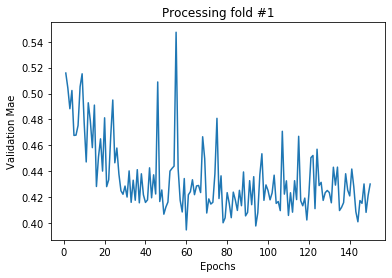

1472/1472 [==============================] - 0s 31us/step
Processing fold # 2
Train on 4415 samples, validate on 1471 samples
Epoch 1/150
4415/4415 [==============================] - 1s 124us/step - loss: 0.9468 - mae: 0.7715 - val_loss: 0.6304 - val_mae: 0.6796
Epoch 2/150
4415/4415 [==============================] - 0s 98us/step - loss: 0.5134 - mae: 0.5725 - val_loss: 0.3048 - val_mae: 0.4335
Epoch 3/150
4415/4415 [==============================] - 0s 96us/step - loss: 0.4483 - mae: 0.5314 - val_loss: 0.3130 - val_mae: 0.4608
Epoch 4/150
4415/4415 [==============================] - 0s 98us/step - loss: 0.4219 - mae: 0.5161 - val_loss: 0.2701 - val_mae: 0.4080
Epoch 5/150
4415/4415 [==============================] - 0s 98us/step - loss: 0.3989 - mae: 0.5035 - val_loss: 0.5290 - val_mae: 0.6155
Epoch 6/150
4415/4415 [==============================] - 0s 98us/step - loss: 0.4022 - mae: 0.5026 - val_loss: 0.3483 - val_mae: 0.4875
Epoch 7/150
4415/4415 [==============================] - 

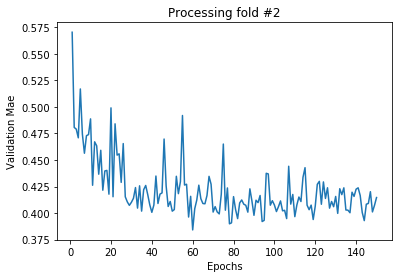

1472/1472 [==============================] - 0s 33us/step
Processing fold # 3
Train on 4415 samples, validate on 1471 samples
Epoch 1/150
4415/4415 [==============================] - 1s 120us/step - loss: 0.8832 - mae: 0.7433 - val_loss: 0.4289 - val_mae: 0.5271
Epoch 2/150
4415/4415 [==============================] - 0s 100us/step - loss: 0.4514 - mae: 0.5340 - val_loss: 0.4690 - val_mae: 0.5444
Epoch 3/150
4415/4415 [==============================] - 0s 99us/step - loss: 0.4050 - mae: 0.5050 - val_loss: 0.4590 - val_mae: 0.5381
Epoch 4/150
4415/4415 [==============================] - 0s 97us/step - loss: 0.3783 - mae: 0.4891 - val_loss: 0.3998 - val_mae: 0.5062
Epoch 5/150
4415/4415 [==============================] - 0s 99us/step - loss: 0.3546 - mae: 0.4759 - val_loss: 0.5413 - val_mae: 0.5770
Epoch 6/150
4415/4415 [==============================] - 0s 100us/step - loss: 0.3537 - mae: 0.4768 - val_loss: 0.6229 - val_mae: 0.6240
Epoch 7/150
4415/4415 [==============================] 

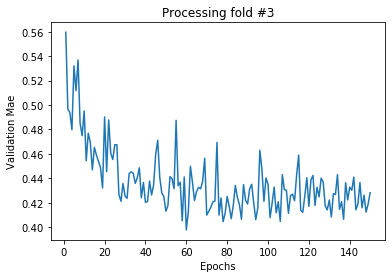

1472/1472 [==============================] - 0s 35us/step
Predict mse: 0.5330591607717392
Predict mae: 0.5597381889820099


In [54]:
"""
mean = train_data.mean(axis=0)
std  = train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std
"""


#++++++++++++++++K-fold validation
k = 4
num_val_samples = len(x_train) // k
num_epochs = 150
all_mae_histories = []
predict_mse = []
predict_mae = []

for i in range(k):
    print('Processing fold #', i)
    val_data = x_train[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate( 
                         [x_train[: i*num_val_samples],
                         x_train[(i+1)*num_val_samples :]],
                         axis = 0)
    partial_train_targets = np.concatenate(
                         [y_train[: i*num_val_samples],
                         y_train[(i+1)*num_val_samples :]],
                         axis = 0)
    model = build_model()
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs,
                        batch_size = 32,
                        verbose = 1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    average_mae_history = [ np.mean([x[i] \
                                    for x in all_mae_histories]) \
                                    for i in range(num_epochs)]
    plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Mae')
    plt.title('Processing fold #%d' %i)
    plt.show()
    
    test_mse, test_mae = model.evaluate(x_test, y_test)
    predict_mse.append(test_mse)
    predict_mae.append(test_mae)

print('Predict mse:', np.array(predict_mse).mean())
print('Predict mae:', np.array(predict_mae).mean())

In [133]:
model = build_model()

history_2 = model.fit(x_train, 
                      y_train,
                      epochs=100,
                      batch_size=64,
                      verbose=1)
test_mse_2, _ = model.evaluate(x_test, y_test)


Epoch 1/100
5886/5886 [==============================] - 0s 51us/step - loss: 1.0506 - mae: 0.8118
Epoch 2/100
5886/5886 [==============================] - 0s 35us/step - loss: 0.5268 - mae: 0.5745
Epoch 3/100
5886/5886 [==============================] - 0s 35us/step - loss: 0.4538 - mae: 0.5341
Epoch 4/100
5886/5886 [==============================] - 0s 37us/step - loss: 0.4361 - mae: 0.5212
Epoch 5/100
5886/5886 [==============================] - 0s 36us/step - loss: 0.4143 - mae: 0.5087
Epoch 6/100
5886/5886 [==============================] - 0s 37us/step - loss: 0.4026 - mae: 0.5000
Epoch 7/100
5886/5886 [==============================] - 0s 35us/step - loss: 0.3803 - mae: 0.4878
Epoch 8/100
5886/5886 [==============================] - 0s 36us/step - loss: 0.3657 - mae: 0.4798
Epoch 9/100
5886/5886 [==============================] - 0s 34us/step - loss: 0.3633 - mae: 0.4753
Epoch 10/100
5886/5886 [==============================] - 0s 37us/step - loss: 0.3521 - mae: 0.4703
Epoch 11/

0.4017742543440798


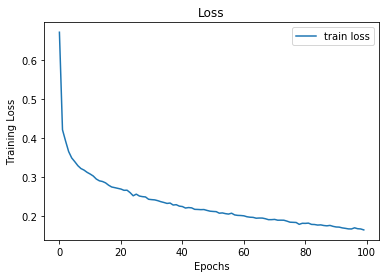

slope: 0.6411644573455987
R2: 0.7051404383733247
p value: 0.0


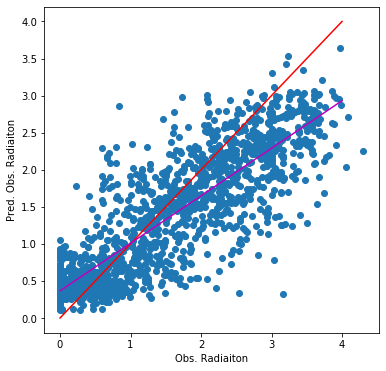

In [116]:
# 3 layers, rmsprop, batch=16, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, model.predict(x_test)[:, 0])
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

0.43508950191671436


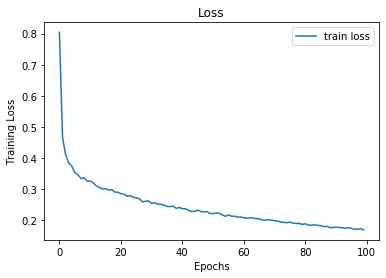

slope: 0.660482798059368
R2: 0.7107415309468609
p value: 0.0


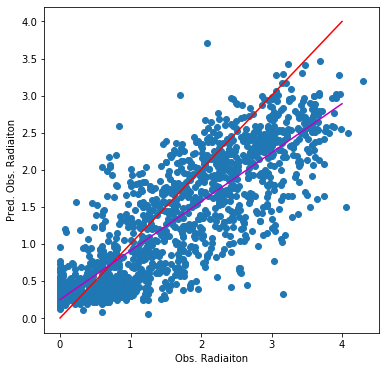

In [124]:
# 3 layers, rmsprop, batch=32, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, model.predict(x_test)[:, 0])
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

0.4864887093072352


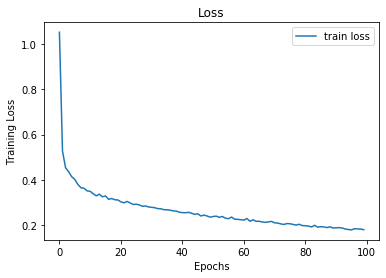

slope: 0.5525493523143014
R2: 0.6674683909853736
p value: 0.0


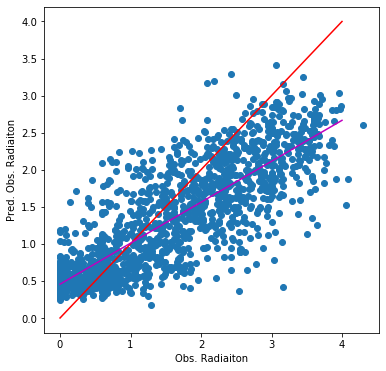

In [134]:
# 3 layers, rmsprop, batch=64, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, model.predict(x_test)[:, 0])
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

0.4147396758198738


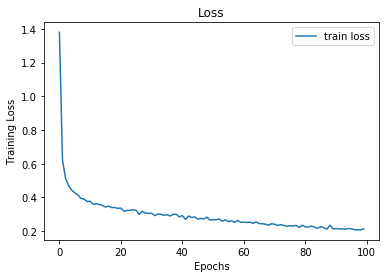

slope: 0.6249755947933198
R2: 0.7027597719717356
p value: 0.0


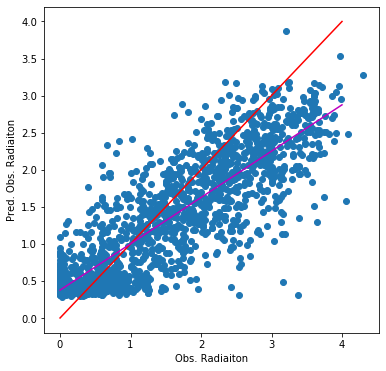

In [130]:
# 3 layers, rmsprop, batch=128, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, model.predict(x_test)[:, 0])
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

0.5455735466726448


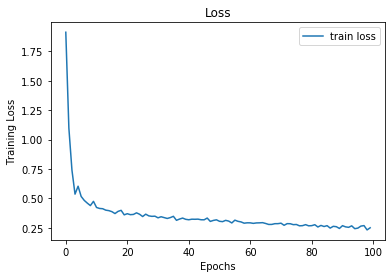

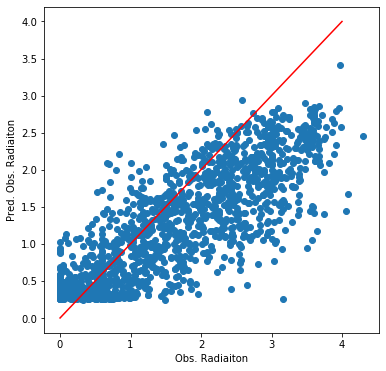

In [80]:
# 3 layers, rmsprop, batch=256, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
plt.show()

0.4610389100144739


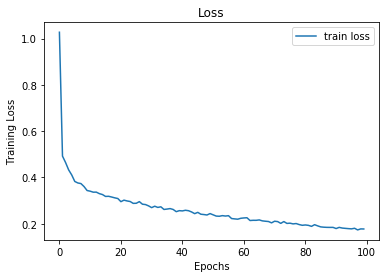

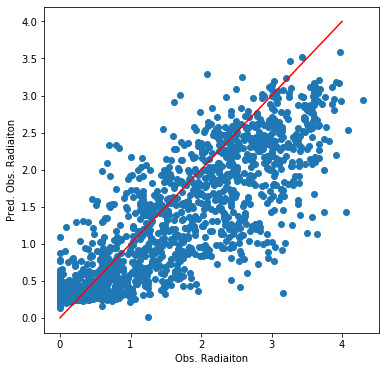

In [72]:
# 3 layers, rmsprop, batch=64, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
plt.show()

0.46097558688210405


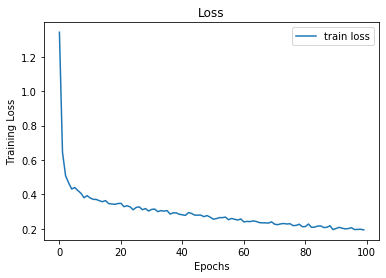

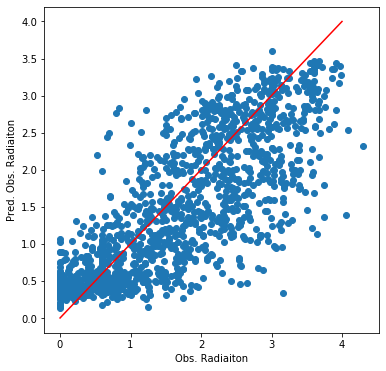

In [83]:
# 6 layers, rmsprop, batch=128, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
plt.show()

0.40889540023129917


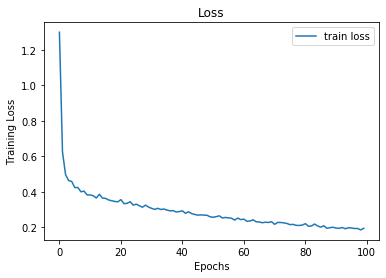

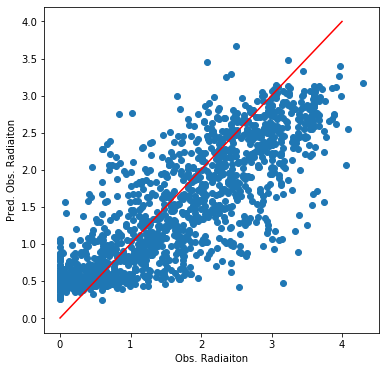

In [86]:
# 6 layers, rmsprop, batch=128, epochs=100
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
plt.show()

0.5052702193674834


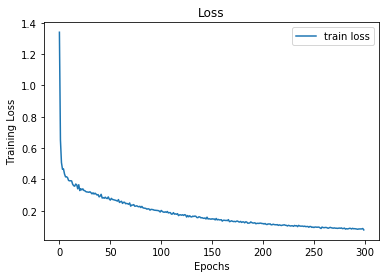

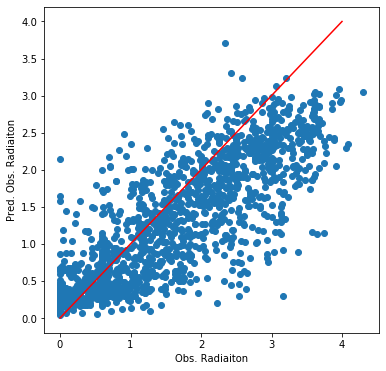

In [88]:
# 4 layers, rmsprop, batch=128, epochs=300
print(test_mse_2)

# Collect results
train_loss = history_2.history["loss"]
#valid_loss = history_2.history["val_loss"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
#plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(x_test))
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
plt.show()

In [93]:
from scipy import stats
print(y_test.shape)
print(model.predict(x_test)[:, 0].shape)
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, model.predict(x_test)[:, 0])
print(slope, intercept, r_value**2, p_value)

(1472,)
(1472,)
0.615810536939186 0.2978221250942025 0.662541459369214 0.0
